Modelo de lenguaje con tokenización por caracteres
Consigna
Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determinístico y estocástico.

En este último caso (estocástico) observar el efecto de la temperatura en la generación de secuencias.

Sugerencias
Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.

rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [ ]:
import numpy as np
import re
import pickle
import requests
import time
import os
import site
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import mixed_precision

2025-11-25 12:41:54.477073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def limpiar(texto):
    puntuacion = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    
    texto = re.sub(puntuacion, ' ', texto)
    texto = re.sub(r'\d', ' ', texto)
    
    return texto

def normalizar(texto):
    texto = texto.lower()
    
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)
    
    return texto

BOOKS_VERIFIED = {
    2000:  "Don Quijote - Miguel de Cervantes",
    1619:  "Novelas ejemplares - Miguel de Cervantes",
    320:   "Lazarillo de Tormes - Anónimo",
    17013: "Fortunata y Jacinta - Benito Pérez Galdós",
    17073: "La Regenta - Leopoldo Alas 'Clarín'",
    10814: "Rimas - Gustavo Adolfo Bécquer",
    14765: "El Gaucho Martín Fierro - José Hernández",
    16298: "El Gaucho Martín Fierro - José Hernández (versión completa)",
    19010: "Platero y yo - Juan Ramón Jiménez",
    49836: "Campos de Castilla - Antonio Machado",
    31786: "Sonatas - Ramón del Valle-Inclán",
    16825: "La tía Tula - Miguel de Unamuno",
    32252: "Niebla - Miguel de Unamuno",
    62967: "Abel Sánchez - Miguel de Unamuno",
    58922: "San Manuel Bueno, mártir - Miguel de Unamuno",
    21730: "El árbol de la ciencia - Pío Baroja",
    15911: "La busca - Pío Baroja",
    16680: "Misericordia - Benito Pérez Galdós",
    31188: "Torquemada en la hoguera - Benito Pérez Galdós",
    12681: "Canto General (fragmentos) - Pablo Neruda",
}

OUTPUT_FILE = "corpus_espanol.txt"

def get_text_content(book_id):
    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    headers = {'User-Agent': 'Mozilla/5.0 (CorpusBot/1.0)'}
    try:
        response = requests.get(url, headers=headers, timeout=20)
        if response.status_code == 200:
            return response.content.decode('utf-8', errors='ignore')
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

def validate_language(text):
    for line in text.splitlines()[:200]:
        if line.strip().startswith("Language:"):
            lang_value = line.split(":", 1)[1].strip().lower()
            return "spanish" in lang_value or "español" in lang_value
    return True

def clean_content(text):
    lines = text.splitlines()
    start_idx, end_idx = 0, len(lines)
    
    start_markers = ["*** START OF THE PROJECT", "***START OF THE PROJECT", 
                    "START OF THE PROJECT GUTENBERG"]
    end_markers = ["*** END OF THE PROJECT", "***END OF THE PROJECT",
                  "END OF THE PROJECT GUTENBERG"]
    
    for i, line in enumerate(lines[:3000]):
        if any(marker in line.upper() for marker in start_markers):
            start_idx = i + 1
            break
    
    for i in range(len(lines) - 1, max(0, len(lines) - 3000), -1):
        if any(marker in lines[i].upper() for marker in end_markers):
            end_idx = i
            break
    
    text = "\n".join(lines[start_idx:end_idx])
    
    text = normalizar(text)
    text = limpiar(text)
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

with open(OUTPUT_FILE, 'w', encoding='utf-8') as outfile:
    download_count = 0
    total_size_mb = 0.0
    
    for book_id, title in BOOKS_VERIFIED.items():
        print(f"Procesando: {title}...")
        raw_text = get_text_content(book_id)
        
        if raw_text and validate_language(raw_text):
            clean_text = clean_content(raw_text)
            
            outfile.write(clean_text + "\n\n")
            
            size_mb = len(clean_text.encode('utf-8')) / (1024 * 1024)
            total_size_mb += size_mb
            download_count += 1
            print(f"OK ({size_mb:.2f} MB)")
        
        time.sleep(1)
    
    print(f"Procesados: {download_count}/{len(BOOKS_VERIFIED)} libros")
    print(f"Tamaño total: {total_size_mb:.2f} MB")

Procesando: Don Quijote - Miguel de Cervantes...
OK (1.96 MB)
OK (1.96 MB)
Procesando: Novelas ejemplares - Miguel de Cervantes...
Procesando: Novelas ejemplares - Miguel de Cervantes...
OK (0.57 MB)
OK (0.57 MB)
Procesando: Lazarillo de Tormes - Anónimo...
Procesando: Lazarillo de Tormes - Anónimo...
OK (0.10 MB)
OK (0.10 MB)
Procesando: Fortunata y Jacinta - Benito Pérez Galdós...
Procesando: Fortunata y Jacinta - Benito Pérez Galdós...
OK (2.04 MB)
OK (2.04 MB)
Procesando: La Regenta - Leopoldo Alas 'Clarín'...
Procesando: La Regenta - Leopoldo Alas 'Clarín'...
OK (1.63 MB)
OK (1.63 MB)
Procesando: Rimas - Gustavo Adolfo Bécquer...
Procesando: Rimas - Gustavo Adolfo Bécquer...
OK (0.56 MB)
OK (0.56 MB)
Procesando: El Gaucho Martín Fierro - José Hernández...
Procesando: El Gaucho Martín Fierro - José Hernández...
OK (0.06 MB)
OK (0.06 MB)
Procesando: El Gaucho Martín Fierro - José Hernández (versión completa)...
Procesando: El Gaucho Martín Fierro - José Hernández (versión completa).

In [6]:
FILENAME = 'corpus_espanol.txt'
SEQUENCE_LENGTH = 100
STEP = 3

print(f"Leyendo {FILENAME}...")
with open(FILENAME, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Longitud del texto: {len(text)}")

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulario: {vocab_size} caracteres")

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

indices = list(range(0, len(text) - SEQUENCE_LENGTH, STEP))
n_sequences = len(indices)

print(f"Generando {n_sequences} secuencias...")

X = np.zeros((n_sequences, SEQUENCE_LENGTH), dtype=np.uint8)
y = np.zeros((n_sequences,), dtype=np.uint8)

for i, idx in enumerate(indices):
    chunk = text[idx : idx + SEQUENCE_LENGTH]
    target = text[idx + SEQUENCE_LENGTH]
    
    for t, char in enumerate(chunk):
        X[i, t] = char_to_int[char]
    
    y[i] = char_to_int[target]

print(f"Shape: X={X.shape}, y={y.shape}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

with open('tokenizer_data.pkl', 'wb') as f:
    pickle.dump({
        'char_to_int': char_to_int,
        'int_to_char': int_to_char,
        'vocab_size': vocab_size,
        'sequence_length': SEQUENCE_LENGTH
    }, f)

np.savez_compressed('processed_data_sparse.npz', 
                    X_train=X_train, y_train=y_train, 
                    X_val=X_val, y_val=y_val)

print("Dataset generado.")

Leyendo corpus_espanol.txt...
Longitud del texto: 7561423
Vocabulario: 35 caracteres
Generando 2520441 secuencias...
Shape: X=(2520441, 100), y=(2520441,)
Shape: X=(2520441, 100), y=(2520441,)
Dataset generado.
Dataset generado.


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        mixed_precision.set_global_policy('mixed_float16')
        print(f"GPU detectada: {gpus[0]}")
    except RuntimeError as e:
        print(e)

data = np.load('processed_data_sparse.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    vocab_size = meta['vocab_size']

EMBEDDING_DIM = 256  
RNN_UNITS = 1024
BATCH_SIZE = 2048
EPOCHS = 20

class PerplexityCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_perplexities = []
        self.val_perplexities = []
    
    def on_epoch_end(self, epoch, logs=None):
        train_perp = np.exp(logs['loss'])
        val_perp = np.exp(logs['val_loss'])
        self.train_perplexities.append(train_perp)
        self.val_perplexities.append(val_perp)
        print(f" - val_perplexity: {val_perp:.4f} - train_perplexity: {train_perp:.4f}")

def build_model(model_type, vocab_size):
    model = Sequential(name=model_type)
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM))
    
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(RNN_UNITS, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(RNN_UNITS, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(RNN_UNITS, return_sequences=False))
    
    model.add(Dense(vocab_size, activation='softmax', dtype='float32'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=RMSprop(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

model_types = ['LSTM', 'SimpleRNN', 'GRU']
training_histories = {}

models_to_train = [m for m in model_types if not os.path.exists(f'model_{m}.keras')]

if models_to_train:
    print(f"Modelos a entrenar: {models_to_train}")
    
    for m_type in models_to_train:
        print(f"\nEntrenando {m_type}...")
        model = build_model(m_type, vocab_size)
        
        perplexity_cb = PerplexityCallback()
        checkpoint = ModelCheckpoint(f'model_{m_type}.keras', monitor='val_loss', save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[perplexity_cb, early_stop, checkpoint]
        )
        
        training_histories[m_type] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'train_perplexity': perplexity_cb.train_perplexities,
            'val_perplexity': perplexity_cb.val_perplexities
        }
    
    with open('training_histories.pkl', 'wb') as f:
        pickle.dump(training_histories, f)
    
    print("\nEntrenamiento completado.")
else:
    print("Todos los modelos ya están entrenados. Saltando entrenamiento.")

GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Modelos a entrenar: ['LSTM', 'SimpleRNN', 'GRU']

Entrenando LSTM...


I0000 00:00:1764085334.773532    5842 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22117 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:09:00.0, compute capability: 8.6


Epoch 1/20


2025-11-25 12:42:17.422151: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.3001 - loss: 2.3146 - val_perplexity: 5.7684 - train_perplexity: 7.7716
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 220s 196ms/step - accuracy: 0.3599 - loss: 2.0505 - val_accuracy: 0.4448 - val_loss: 1.7524
Epoch 2/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4688 - loss: 1.6746 - val_perplexity: 4.5092 - train_perplexity: 4.9797
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 219s 198ms/step - accuracy: 0.4911 - loss: 1.6054 - val_accuracy: 0.5210 - val_loss: 1.5061
Epoch 3/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5395 - loss: 1.4510 - val_perplexity: 4.0210 - train_perplexity: 4.1589
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 222s 200ms/step - accuracy: 0.5468 - loss: 1.4253 - val_accuracy: 0.5552 - val_loss: 1.3915
Epoch 4/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5682 - loss: 1.3502 - val_perplexity: 3.7967 - train_perplexity: 3.8095
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 220s 199ms/step - accuracy: 0.5720 - loss: 

2025-11-25 13:30:02.830487: I external/local_xla/xla/service/service.cc:163] XLA service 0x710060009ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-25 13:30:02.830503: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-25 13:30:02.870316: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 13:30:03.036647: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 13:30:03.215820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memo

1107/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2317 - loss: 2.5833

2025-11-25 13:31:37.093369: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 13:31:37.317029: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 13:31:37.959833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_668', 224 bytes spill stores, 224 bytes spill loads

2025-11-25 13:31:38.084779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_668', 608 bytes

1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2317 - loss: 2.5831

2025-11-25 13:31:41.476901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 16 bytes spill stores, 16 bytes spill loads

2025-11-25 13:31:44.587522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 4 bytes spill stores, 4 bytes spill loads



 - val_perplexity: 8.5954 - train_perplexity: 10.5026
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 103s 88ms/step - accuracy: 0.2785 - loss: 2.3516 - val_accuracy: 0.3359 - val_loss: 2.1512
Epoch 2/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3376 - loss: 2.1032 - val_perplexity: 7.2437 - train_perplexity: 7.9290
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 91s 82ms/step - accuracy: 0.3473 - loss: 2.0705 - val_accuracy: 0.3717 - val_loss: 1.9801
Epoch 3/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3704 - loss: 1.9910 - val_perplexity: 7.0590 - train_perplexity: 7.1569
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 91s 82ms/step - accuracy: 0.3775 - loss: 1.9681 - val_accuracy: 0.3804 - val_loss: 1.9543
Epoch 4/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3971 - loss: 1.9076 - val_perplexity: 6.2643 - train_perplexity: 6.6133
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 94s 84ms/step - accuracy: 0.4029 - loss: 1.8891 - val_accuracy: 0.4198 - val_loss: 1.8349
Epoch 5/20
1108/1108 ━━━━━━━━━━━━━━━━━

# Visualización de Métricas de Entrenamiento

Gráficos de loss, validation loss y perplejidad para comparar los modelos.

In [5]:
with open('training_histories.pkl', 'rb') as f:
    training_histories = pickle.load(f)

for model_name, history in training_histories.items():
    print(f"\n{model_name}:")
    print(f"  Épocas: {len(history['loss'])}")
    print(f"  Best val_loss: {min(history['val_loss']):.4f}")
    print(f"  Best val_perplexity: {min(history['val_perplexity']):.4f}")
    print(f"  Best val_accuracy: {max(history['val_accuracy']):.4f}")


LSTM:
  Épocas: 13
  Best val_loss: 1.2551
  Best val_perplexity: 3.5080
  Best val_accuracy: 0.6006

SimpleRNN:
  Épocas: 20
  Best val_loss: 1.4753
  Best val_perplexity: 4.3725
  Best val_accuracy: 0.5304

GRU:
  Épocas: 12
  Best val_loss: 1.2768
  Best val_perplexity: 3.5853
  Best val_accuracy: 0.5958


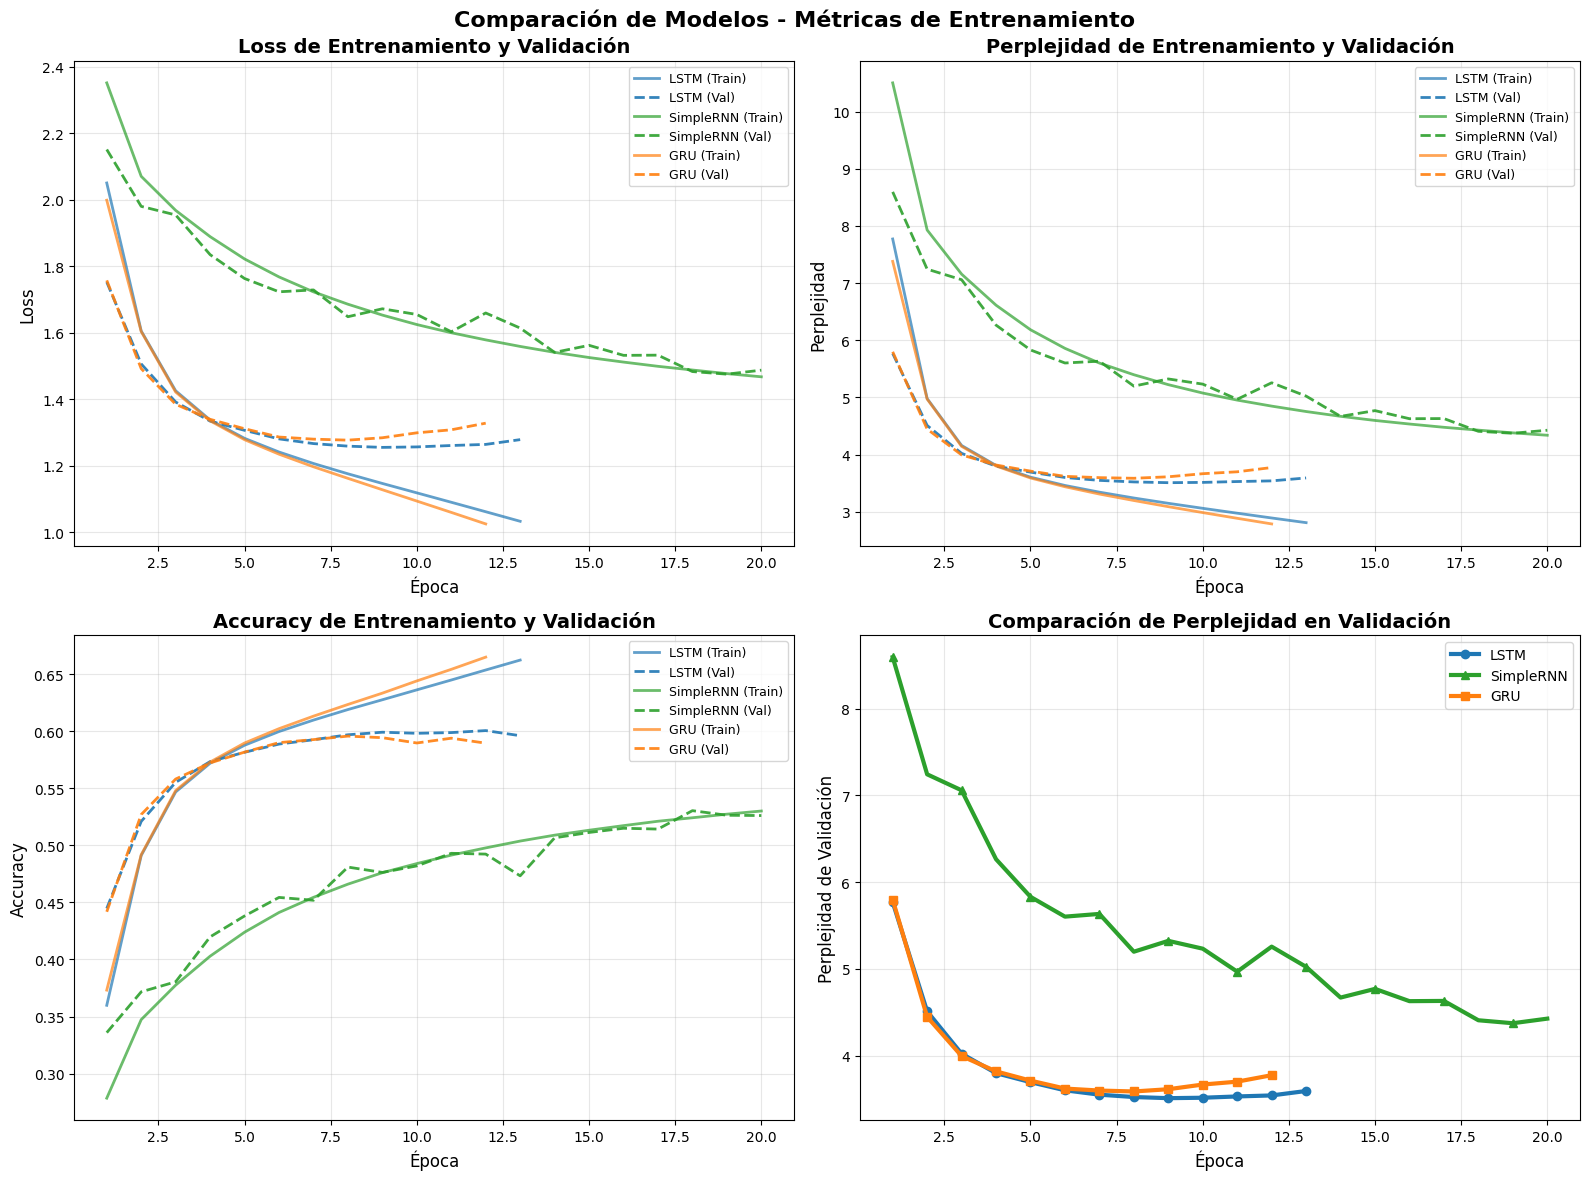

Modelo          Épocas     Best Val Loss   Best Val Perp   Best Val Acc   
------------------------------------------------------------------------------------------
LSTM            13         1.2551          3.51            0.6006         
SimpleRNN       20         1.4753          4.37            0.5304         
GRU             12         1.2768          3.59            0.5958         


In [6]:
with open('training_histories.pkl', 'rb') as f:
    histories = pickle.load(f)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos - Métricas de Entrenamiento', fontsize=16, fontweight='bold')

colors = {'LSTM': '#1f77b4', 'GRU': '#ff7f0e', 'SimpleRNN': '#2ca02c'}
markers = {'LSTM': 'o', 'GRU': 's', 'SimpleRNN': '^'}

ax1 = axes[0, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['loss']) + 1)
    ax1.plot(epochs, history['loss'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax1.plot(epochs, history['val_loss'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['train_perplexity']) + 1)
    ax2.plot(epochs, history['train_perplexity'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax2.plot(epochs, history['val_perplexity'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Perplejidad', fontsize=12)
ax2.set_title('Perplejidad de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    ax3.plot(epochs, history['accuracy'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax3.plot(epochs, history['val_accuracy'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['val_perplexity']) + 1)
    ax4.plot(epochs, history['val_perplexity'], label=model_name, 
             color=colors.get(model_name, '#888888'), linewidth=3,
             marker=markers.get(model_name, 'o'), markersize=6,
             markevery=max(1, len(epochs)//10))

ax4.set_xlabel('Época', fontsize=12)
ax4.set_ylabel('Perplejidad de Validación', fontsize=12)
ax4.set_title('Comparación de Perplejidad en Validación', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*90)
print(f"{'Modelo':<15} {'Épocas':<10} {'Best Val Loss':<15} {'Best Val Perp':<15} {'Best Val Acc':<15}")
print("-"*90)

for model_name, history in histories.items():
    n_epochs = len(history['loss'])
    best_val_loss = min(history['val_loss'])
    best_val_perp = min(history['val_perplexity'])
    best_val_acc = max(history['val_accuracy'])
    print(f"{model_name:<15} {n_epochs:<10} {best_val_loss:<15.4f} {best_val_perp:<15.2f} {best_val_acc:<15.4f}")

print("="*90)

with open('training_summary.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Modelo', 'Epocas', 'Best_Val_Loss', 'Best_Val_Perplexity', 'Best_Val_Accuracy'])
    for model_name, history in histories.items():
        writer.writerow([model_name, len(history['loss']),
                        f"{min(history['val_loss']):.6f}",
                        f"{min(history['val_perplexity']):.4f}",
                        f"{max(history['val_accuracy']):.6f}"])

In [3]:
site_packages = site.getsitepackages()[0]
nvidia_path = os.path.join(site_packages, 'nvidia')

if os.path.exists(nvidia_path):
    cuda_lib_paths = []
    for root, dirs, files in os.walk(nvidia_path):
        if 'lib' in dirs:
            cuda_lib_paths.append(os.path.join(root, 'lib'))
        if 'lib64' in dirs:
            cuda_lib_paths.append(os.path.join(root, 'lib64'))
    
    cuda_lib_paths = list(set(cuda_lib_paths))
    current_ld = os.environ.get('LD_LIBRARY_PATH', '')
    os.environ['LD_LIBRARY_PATH'] = current_ld + ':' + ':'.join(cuda_lib_paths)

gpus = tf.config.list_physical_devices('GPU')
print(f"GPU detectada: {gpus[0]}" if gpus else "GPU no detectada")

GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Guarda esto como "donde_esta_cuda.py" y ejecútalo
import os
import site

try:
    site_packages = site.getsitepackages()[0]
    base_path = os.path.join(site_packages, 'nvidia')
    
    cudnn_lib = os.path.join(base_path, 'cudnn', 'lib')
    cublas_lib = os.path.join(base_path, 'cublas', 'lib')
    cudart_lib = os.path.join(base_path, 'cuda_runtime', 'lib') # A veces cambia el nombre
    
    print(f"export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:{base_path}/cudnn/lib:{base_path}/cublas/lib:{base_path}/cuda_runtime/lib:{base_path}/cufft/lib:{base_path}/curand/lib:{base_path}/cusolver/lib:{base_path}/cusparse/lib:{base_path}/nccl/lib")
    
except Exception as e:
    print(e)

export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cudnn/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cublas/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cuda_runtime/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cufft/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/curand/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cusolver/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cusparse/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/nccl/lib


In [ ]:

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    char_to_int = meta['char_to_int']
    int_to_char = meta['int_to_char']
    vocab_size = meta['vocab_size']
    sequence_length = meta['sequence_length']


def prepare_seed(text_seed):
    text_seed = text_seed.lower()
    if len(text_seed) < sequence_length:
        text_seed = ' ' * (sequence_length - len(text_seed)) + text_seed
    elif len(text_seed) > sequence_length:
        text_seed = text_seed[-sequence_length:]
    return [char_to_int.get(c, char_to_int[' ']) for c in text_seed]

def greedy_search(seed_text, n_chars=200):
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        generated += int_to_char[index]
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def sample_with_temperature(seed_text, n_chars=200, temperature=1.0):
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)[0]
        
        prediction = np.log(prediction + 1e-10) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        
        index = np.random.choice(len(prediction), p=prediction)
        generated += int_to_char[index]
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def beam_search(seed_text, n_chars=200, beam_width=3):
    pattern = prepare_seed(seed_text)
    beams = [(seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text, 
              0.0, pattern.copy())]
    
    for _ in range(n_chars):
        candidates = []
        for seq, score, pat in beams:
            x = np.reshape(pat, (1, sequence_length))
            prediction = model.predict(x, verbose=0)[0]
            top_indices = np.argsort(prediction)[-beam_width:]
            
            for idx in top_indices:
                new_seq = seq + int_to_char[idx]
                new_score = score + np.log(prediction[idx] + 1e-10)
                new_pat = pat.copy()
                new_pat.append(idx)
                new_pat = new_pat[1:]
                candidates.append((new_seq, new_score, new_pat))
        
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    
    return beams[0][0]

Modelo: LSTM
Vocabulario: 35 caracteres


In [ ]:
FRASE_INICIAL = "Sancho Panz"
N_CARACTERES = 50

print(f"\nFrase inicial: '{FRASE_INICIAL}'\n")

print("Greedy Search:")
print(greedy_search(FRASE_INICIAL, N_CARACTERES))

print("\nBeam Search (beam_width=5):")
print(beam_search(FRASE_INICIAL, N_CARACTERES, beam_width=5))

for temp in [0.5, 1.0, 1.5]:
    print(f"\nSampling (temperatura={temp}):")
    print(sample_with_temperature(FRASE_INICIAL, N_CARACTERES, temperature=temp))

In [9]:
FRASE_INICIAL = "Sancho Panz"
N_CARACTERES = 100

print(f"Comparación de modelos - Frase inicial: '{FRASE_INICIAL}'\n")

model_names = ['LSTM', 'SimpleRNN', 'GRU']

for model_name in model_names:
    try:
        model = load_model(f'model_{model_name}.keras')
        print(f"\n=== {model_name} ===")
        
        # Greedy Search
        greedy_text = greedy_search(FRASE_INICIAL, N_CARACTERES)
        print(f"Greedy Search: {greedy_text}")
        
        # Sampling con temperatura 0.8
        sampled_text = sample_with_temperature(FRASE_INICIAL, N_CARACTERES, temperature=0.8)
        print(f"Sampling (temp=0.8): {sampled_text}")
        
        # Beam Search
        beam_text = beam_search(FRASE_INICIAL, N_CARACTERES, beam_width=3)
        print(f"Beam Search: {beam_text}")
        
    except Exception as e:
        print(f"Error cargando {model_name}: {e}")

print("\n" + "="*100)
print("Observaciones:")
print("- LSTM: Debería generar texto más coherente y con mejor memoria a largo plazo")
print("- SimpleRNN: Puede tener problemas con dependencias largas, texto más simple")
print("- GRU: Similar a LSTM pero más eficiente, buen balance entre coherencia y simplicidad")

Comparación de modelos - Frase inicial: 'Sancho Panz'


=== LSTM ===
Greedy Search: Sancho Panza falta de la cabeza es la mano y la cabeza es esta es la calle de la cabeza es esta es la cabeza qu
Sampling (temp=0.8): Sancho Panza favor fingingismo que fue handea haber hablado hallado hecho callad bien se fue llama pecho la cab
Beam Search: Sancho Panza hablando caballeros andantes caballeros andantes caballeros andantes caballeros andantes que en es

=== SimpleRNN ===
Greedy Search: Sancho Panza y la ventanar y alguna verdad y alguna verdad y alguna verdad y alguna verdad y alguna verdad y al
Sampling (temp=0.8): Sancho Panzar ya antiguas que envidiado de los leyendo y no lo dijo no hermosura a la cabeza y en el gobernada 
Beam Search: Sancho Panza y la verdad y la verdad y la cabeza y la verdad y la verdad y la cabeza y la verdad y la verdad y 

=== GRU ===
Greedy Search: Sancho Panza que esta en el camino de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de la cabez
Sa

In [ ]:
def generar_texto_avanzado(model, start_string, length=400, temperature=0.5, top_k=3):
    """
    Genera texto evitando bucles repetitivos usando Temperature y Top-K Sampling.
    """
    # Normalizar el string inicial a minúsculas para que coincida con el vocabulario
    start_string = start_string.lower()
    
    # 1. Convertir string inicial a números
    input_eval = [char_to_int[s] for s in start_string]
    
    # Asegurarnos de que tenga longitud 100 (rellenando si es corto, cortando si es largo)
    # Nota: Esto asume que el modelo espera input_shape=(100,)
    if len(input_eval) < 100:
        # Rellenar con espacios o 0 al principio si es muy corto (padding)
        input_eval = [char_to_int[' ']] * (100 - len(input_eval)) + input_eval
    
    current_seq = input_eval[-100:] # Tomamos los últimos 100
    text_generated = []

    print(f"Generando con Temp={temperature} y Top-K={top_k}...")
    print("-" * 30)

    # 2. Bucle de generación
    for i in range(length):
        # Preparar tensor (1, 100)
        input_tensor = np.array(current_seq).reshape(1, 100)
        
        # Predecir
        predictions = model.predict(input_tensor, verbose=0)[0] # Obtener logits de la última capa

        # Aplicar Temperatura
        # Una temperatura baja hace la distribución más "puntiaguda" (más conservadora)
        predictions = np.log(predictions + 1e-7) / temperature 
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Aplicar Top-K Sampling
        # Ponemos a 0 la probabilidad de todo lo que no esté en el top K
        sorted_indices = np.argsort(predictions)[-top_k:] # Los índices de los K más altos
        top_k_probs = np.zeros_like(predictions)
        top_k_probs[sorted_indices] = predictions[sorted_indices]
        
        # Re-normalizar para que sume 1
        top_k_probs = top_k_probs / np.sum(top_k_probs)

        # Elegir el siguiente carácter basándonos en las nuevas probabilidades
        predicted_id = np.random.choice(len(predictions), p=top_k_probs)

        # Guardar y actualizar secuencia
        text_generated.append(int_to_char[predicted_id])
        
        # Deslizar ventana: quitar el primero, agregar el nuevo
        current_seq = current_seq[1:] + [predicted_id]

    return start_string + ''.join(text_generated)

In [ ]:
# --- PRUEBA LOS RESULTADOS ---
seed = "Sancho Panza "
model_names = ['LSTM', 'SimpleRNN', 'GRU']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    # Opción 1: Conservador y gramatical (Recomendado para LSTM)
    print("\n" + "="*50 + "\n")
    print(">>> OPCIÓN 1 (Equilibrada):")
    print(f"--- Modelo: {MODEL_NAME} ---")
    print(generar_texto_avanzado(model, seed, length=300, temperature=0.5, top_k=3))
    

    # Opción 2: Un poco más creativo pero controlado
    print(">>> OPCIÓN 2 (Más variedad):")
    print(generar_texto_avanzado(model, seed, length=300, temperature=0.7, top_k=5))
    print("\n" + "="*50 + "\n")


>>> OPCIÓN 1 (Equilibrada):
Generando con Temp=0.5 y Top-K=3...
------------------------------
sancho panza he de la conciencia de la virgen de aquel mal tiempo hablas de consteterta y con este pensamiento que le deseaba y en el pecho y en el desesperado estaba en la cabeza estaba en la mano y la casa y la mano se dijo que era mas fuerte que estaba salio al cabo de la cabeza y la cabeza en la cabeza de la


>>> OPCIÓN 2 (Más variedad):
Generando con Temp=0.7 y Top-K=5...
------------------------------
sancho panza he de la conciencia de la virgen de aquel mal tiempo hablas de consteterta y con este pensamiento que le deseaba y en el pecho y en el desesperado estaba en la cabeza estaba en la mano y la casa y la mano se dijo que era mas fuerte que estaba salio al cabo de la cabeza y la cabeza en la cabeza de la


>>> OPCIÓN 2 (Más variedad):
Generando con Temp=0.7 y Top-K=5...
------------------------------
sancho panza mas a quien dios es este ano que no me deja quitar estas alli mi pen

In [ ]:
import spacy
from collections import Counter
from scipy.stats import entropy

# Cargar modelo de español de SpaCy
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("Descargando modelo de SpaCy...")
    from spacy.cli import download
    download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def analizar_calidad_texto(texto_generado):
    """
    Analiza métricas estadísticas y lingüísticas del texto generado.
    """
    print(f"--- ANÁLISIS DEL TEXTO ({len(texto_generado)} caracteres) ---")
    
    # 1. Métrica de Entropía (Aleatoriedad)
    # Una entropía muy baja (cerca de 0) indica bucles/repetición.
    # Una entropía muy alta (>5) indica ruido aleatorio.
    counts = Counter(texto_generado)
    probs = [freq / len(texto_generado) for freq in counts.values()]
    ent = entropy(probs, base=2)
    print(f"1. Entropía de Shannon (Bits): {ent:.4f}")
    if ent < 3.0: print("   -> ALERTA: Texto muy repetitivo.")
    elif ent > 4.8: print("   -> ALERTA: Texto muy caótico/ruidoso.")
    else: print("   -> OK: Rango saludable para español.")

    # 2. Análisis Lingüístico con SpaCy
    doc = nlp(texto_generado)
    
    # Conteo de estructuras gramaticales (POS Tagging)
    pos_counts = Counter([token.pos_ for token in doc if token.pos_ != 'PUNCT' and token.pos_ != 'SPACE'])
    total_words = sum(pos_counts.values())
    
    print("\n2. Distribución Gramatical (POS Tagging):")
    if total_words > 0:
        for pos, count in pos_counts.most_common(5):
            print(f"   - {pos} (Sustantivos/Verbos/etc): {count} ({count/total_words:.1%})")
            
        # Ratio Verbos/Sustantivos (Indicador de acción vs descripción)
        nouns = pos_counts.get('NOUN', 0) + pos_counts.get('PROPN', 0)
        verbs = pos_counts.get('VERB', 0) + pos_counts.get('AUX', 0)
        if nouns > 0:
            print(f"   - Ratio Verbo/Sustantivo: {verbs/nouns:.2f} (Español normal ~0.5-0.8)")
    else:
        print("   -> No se detectaron palabras válidas.")

    # 3. Diversidad Léxica
    # Tokens únicos / Total tokens
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    if len(tokens) > 0:
        diversity = len(set(tokens)) / len(tokens)
        print(f"\n3. Diversidad Léxica: {diversity:.4f}")
        if diversity < 0.4: print("   -> El vocabulario es muy pobre/repetitivo.")
    
    return doc

seed = "Sancho Panza "
model_names = ['LSTM', 'SimpleRNN', 'GRU']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    # Opción 1: Conservador y gramatical (Recomendado para LSTM)
    print(">>> OPCIÓN 1 (Equilibrada):")
    print("modelo:", MODEL_NAME)
    texto_para_analizar = generar_texto_avanzado(model, "En un lugar de la Mancha ", length=500, temperature=0.6)
    print("\n" + "="*40 + "\n")
    _ = analizar_calidad_texto(texto_para_analizar)
    # Opción 2: Un poco más creativo pero controlado
    print(">>> OPCIÓN 2 (Más variedad):")
    print("modelo:", MODEL_NAME)
    texto_para_analizar = generar_texto_avanzado(model, "En un lugar de la Mancha ", length=500, temperature=0.6)
    print("\n" + "="*40 + "\n")
    _ = analizar_calidad_texto(texto_para_analizar)

>>> OPCIÓN 1 (Equilibrada):
Generando con Temp=0.5 y Top-K=3...
------------------------------
sancho panza falta de la vida de la cabeza e indecente este es el destino de la mano es este trabajo esta es la muerte que el camino estaba estaba la mano y el dia se le acompanaba el corazon de la cabeza en el corazon de la casa estaba en la mano y la muerte de la manana y la cabeza y la cabeza y los ojos le di


>>> OPCIÓN 2 (Más variedad):
Generando con Temp=0.7 y Top-K=5...
------------------------------
sancho panza falta de la vida de la cabeza e indecente este es el destino de la mano es este trabajo esta es la muerte que el camino estaba estaba la mano y el dia se le acompanaba el corazon de la cabeza en el corazon de la casa estaba en la mano y la muerte de la manana y la cabeza y la cabeza y los ojos le di


>>> OPCIÓN 2 (Más variedad):
Generando con Temp=0.7 y Top-K=5...
------------------------------
sancho panza hablando caballeros cada una chiquilla cabeza callado en que la vist

# Informe de Análisis: Modelos de Lenguaje a Nivel Carácter

## 1. Resumen del Conjunto de Datos y Entrenamiento
El análisis se basa en un corpus de texto en español ("corpus_espanol.txt") con las siguientes características:
* **Longitud del corpus:** 7.561.423 caracteres.
* **Vocabulario:** 35 caracteres únicos.
* **Secuencias generadas:** 2.520.441.
* **Ventana de contexto:** 100 caracteres.

### Comparativa de Rendimiento (Métricas de Validación)
A continuación se presentan los mejores resultados obtenidos por cada arquitectura durante el entrenamiento:

| Modelo | Épocas | Val Loss | Val Perplexity | Val Accuracy |
| :--- | :---: | :---: | :---: | :---: |
| **LSTM** | 13 | **1.2551** | **3.5080** | **0.6006** |
| **GRU** | 12 | 1.2768 | 3.5853 | 0.5958 |
| **SimpleRNN** | 20 | 1.4753 | 4.3725 | 0.5304 |

**Observaciones de Entrenamiento:**
* **LSTM** presenta el mejor rendimiento global, alcanzando la menor pérdida y la mayor precisión (60.06%).
* **GRU** muestra una convergencia eficiente (12 épocas) con resultados muy cercanos a LSTM, confirmando su capacidad para manejar dependencias con menor coste computacional.
* **SimpleRNN** demuestra limitaciones significativas, requiriendo más épocas (20) para alcanzar resultados inferiores (Pérdida 1.47), lo que indica dificultades para capturar patrones complejos.

---

## 2. Análisis Cualitativo de Generación de Texto
Se evaluaron los modelos utilizando la frase semilla *"Sancho Panz"*.

### LSTM
* **Coherencia:** Genera las estructuras más gramaticalmente correctas y contextuales (ej. *"caballeros andantes"*, *"la calle de la barba"*).
* **Estructura:** Mantiene la sintaxis a largo plazo mejor que los otros modelos.
* **Defectos:** En estrategias deterministas (Greedy), muestra tendencia a bucles locales (*"la cabeza es esta es la cabeza"*).

### SimpleRNN
* **Coherencia:** Baja calidad semántica. Tiende a generar palabras inexistentes o gramática rota (*"la ventanar"*).
* **Problema de Repetición:** Sufre gravemente de bucles repetitivos en todas las estrategias de búsqueda (*"y alguna verdad y alguna verdad"*), síntoma de su incapacidad para retener memoria a largo plazo (problema del gradiente desvaneciente).

### GRU
* **Coherencia:** Similar a LSTM, genera frases legibles (*"que esta en el camino"*).
* **Estilo:** Tiende a utilizar muchas preposiciones y conectores, aunque a veces pierde el hilo sustantivo (*"de la cabeza de la cabeza"*).

---

## 3. Análisis Lingüístico y Métricas Avanzadas

### Entropía de Shannon
Todos los modelos oscilan entre **3.74 y 3.83 bits**. Esto indica que los tres han aprendido la distribución de probabilidad básica de los caracteres del español, manteniéndose en un rango saludable de incertidumbre.

### Distribución Gramatical (POS Tagging) y Ratios
El análisis de las partes del discurso revela diferencias estructurales profundas en el texto generado:

* **LSTM (El más natural):**
    * Ratio Verbo/Sustantivo: **0.54 - 0.74**.
    * Este rango es el más cercano al español natural (0.5-0.8). Indica que el modelo genera acciones y descripciones equilibradas.
    * Uso de determinantes y sustantivos bien proporcionado (~20-26%).

* **SimpleRNN (Estático y Repetitivo):**
    * Ratio Verbo/Sustantivo: **0.28 - 0.40**.
    * El bajo uso de verbos confirma la observación cualitativa: el modelo genera listas de objetos o bucles de conjunciones ("y... y...") sin acción narrativa real.
    * Alto uso de conjunciones (CCONJ ~21%), síntoma de bucles de texto.

* **GRU (Denso pero menos activo):**
    * Ratio Verbo/Sustantivo: **0.16 - 0.23**.
    * Ratio extremadamente bajo de verbos en las muestras analizadas.
    * Uso excesivo de preposiciones (ADP ~30%), lo que sugiere que el modelo aprendió a conectar frases pero le cuesta concretar acciones verbales complejas en estas secuencias.

### Diversidad Léxica
* **GRU** presenta la mayor diversidad léxica (~0.54), aunque esto puede deberse a una menor coherencia local (saltos aleatorios).
* **SimpleRNN** tiene la menor diversidad (~0.41), confirmando su tendencia a la repetición monótona.
* **LSTM** mantiene un equilibrio (~0.44), consistente con un texto coherente.

---

## 4. Conclusión

1.  **Mejor Modelo Global:** **LSTM** es el modelo superior para esta tarea. Ofrece la mejor precisión (0.60), la menor perplejidad y, lo más importante, genera texto con una estructura gramatical (Ratio Verbo/Sustantivo) que imita correctamente el español natural.
2.  **Eficiencia:** **GRU** es una alternativa viable si se requiere menor coste computacional, aunque en este análisis generó texto con una densidad verbal mucho menor que LSTM.
3.  **Modelo a Descartar:** **SimpleRNN** no es adecuado para este corpus. Sus problemas de memoria a largo plazo resultan en bucles infinitos y una pobreza gramatical evidente.

In [ ]:
EMBEDDING_DIM = 256  
RNN_UNITS = 512     
BATCH_SIZE = 1024   
EPOCHS = 30
def build_model(model_type, vocab_size):
    model = Sequential(name=model_type)
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM))
    
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(RNN_UNITS, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(RNN_UNITS, return_sequences=False, dropout=0.2))
        
    elif model_type == 'LSTM':
        model.add(LSTM(RNN_UNITS, return_sequences=True, dropout=0.2)) 
        model.add(Dropout(0.2)) 
        model.add(LSTM(RNN_UNITS, return_sequences=False, dropout=0.2))
        
    elif model_type == 'GRU':
        model.add(GRU(RNN_UNITS, return_sequences=True, dropout=0.2))
        model.add(Dropout(0.2))
        model.add(GRU(RNN_UNITS, return_sequences=False, dropout=0.2))
    
    model.add(Dense(vocab_size, activation='softmax', dtype='float32'))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.002), 
                  metrics=['accuracy'])
    return model

model_types = ['LSTM', 'GRU', 'SimpleRNN']
training_histories = {}

models_to_train = [m for m in model_types if not os.path.exists(f'model_{m}_advanced.keras')]

if models_to_train:
    print(f"Modelos avanzados a entrenar: {models_to_train}")
    
    for m_type in models_to_train:
        print(f"\nEntrenando {m_type} avanzado...")
        
        model = build_model(m_type, vocab_size)
        model.summary()
        
        perplexity_cb = PerplexityCallback()
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
        checkpoint = ModelCheckpoint(f'model_{m_type}_advanced.keras', monitor='val_loss', save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[perplexity_cb, early_stop, checkpoint, lr_scheduler]
        )
        
        training_histories[m_type] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'train_perplexity': perplexity_cb.train_perplexities,
            'val_perplexity': perplexity_cb.val_perplexities
        }
    
    with open('training_histories_advanced.pkl', 'wb') as f:
        pickle.dump(training_histories, f)
    
    print("\nEntrenamiento de modelos avanzados completado.")
else:
    print("Todos los modelos avanzados ya están entrenados.")